## 1. Setup and Imports

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

✓ Libraries imported successfully
PyTorch version: 2.9.0+cu128


In [9]:
pi = np.pi

## 3. Normalizing Flow Components

DINGO uses **normalizing flows** to transform a simple base distribution (e.g., Gaussian) into a complex posterior distribution.

We'll implement:
1. **Coupling layers** - Core flow transformation
2. **Base distribution** - Standard Gaussian
3. **Flow composition** - Stack multiple transformations

In [10]:
class AffineCouplingLayer(nn.Module):
    """
    Affine coupling layer for normalizing flows
    
    Splits input, transforms one half conditioned on the other:
    x2_new = x2 * exp(s(x1, context)) + t(x1, context)
    """
    def __init__(self, dim, context_dim, hidden_dim=128, mask_type='half'):
        super().__init__()
        self.dim = dim
        
        # Create mask (which dimensions to transform)
        # For 2D: 'even' = [1,0] (transform 2nd), 'odd' = [0,1] (transform 1st)
        # For 3D: 'even' = [1,0,1] (transform 2nd), 'odd' = [0,1,0] (transform 1st & 3rd)
        self.register_buffer('mask', torch.zeros(dim))
        if mask_type in ['half', 'even']:
            self.mask[::2] = 1  # Set every other dimension starting from 0: [1,0,1,0,...]
        elif mask_type == 'odd':
            self.mask[1::2] = 1  # Set every other dimension starting from 1: [0,1,0,1,...]
        
        # Networks for scale (s) and translation (t)
        self.scale_net = nn.Sequential(
            nn.Linear(dim + context_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()  # Stabilize training
        )
        
        self.translation_net = nn.Sequential(
            nn.Linear(dim + context_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
    
    def forward(self, x, context, reverse=False):
        """
        Forward (data -> latent) or reverse (latent -> data) transformation
        
        Args:
            x: input tensor [batch_size, dim]
            context: conditioning context (embedded data) [batch_size, context_dim]
            reverse: if True, compute inverse transformation
        
        Returns:
            output: transformed tensor
            log_det: log determinant of Jacobian
        """
        masked_x = x * self.mask # Split data into a masked and unmasked part. 
                                 # The unmasked part is kept the same and is used for conditioning. The masked part is set to 0, to be transformed (but how does this work?)
        
        # Concatenate masked input with context
        scale_input = torch.cat([masked_x, context], dim=1) 
        translation_input = torch.cat([masked_x, context], dim=1) # These two literally concatenate masked_x and context along. 
                                                                  # So if masked_x is [2.5] and context is [0.3, -0.1, ...], then scale_input is [2.5, 0.3, -0.1, ...]
                                                                  # In this case, context is a compressed sine wave, and masked_x is the amplitude. So the first number in this concatenation is the amplitude, and the rest are the sine wave values.
                                                                  # So of course, during training, the network is passed thousands of these examples, so it learns that the first number is the amplitude, and the rest are the sine wave values.
                                                                 
        # Compute scale and translation
        s = self.scale_net(scale_input)
        t = self.translation_net(translation_input)
        
        # Only apply to unmasked dimensions
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        if not reverse:
            # Forward: x -> z
            y = x * torch.exp(s) + t
            log_det = s.sum(dim=1)
        else:
            # Reverse: z -> x
            y = (x - t) * torch.exp(-s)
            log_det = -s.sum(dim=1)
        
        return y, log_det

print("✓ Coupling layer defined")

✓ Coupling layer defined


In [11]:
class NormalizingFlow(nn.Module):   # Just the normalising flow class. 
    """
    Normalizing flow: stack of coupling layers
    Transforms base distribution into complex posterior
    """
    def __init__(self, param_dim=1, context_dim=64, num_layers=6, hidden_dim=128):
        super().__init__()
        self.param_dim = param_dim
        self.context_dim = context_dim
        
        # Stack of coupling layers with alternating masks
        self.layers = nn.ModuleList([
            AffineCouplingLayer(
                dim=param_dim,
                context_dim=context_dim,
                hidden_dim=hidden_dim,
                mask_type='even' if i % 2 == 0 else 'odd'
            )
            for i in range(num_layers)
        ])
        
        # Base distribution: standard Gaussian 
        self.register_buffer('base_mean', torch.zeros(param_dim))
        self.register_buffer('base_std', torch.ones(param_dim))
    
    def forward(self, params, context):
        """
        Forward pass: compute log probability of parameters given context
        
        Args:
            params: parameter values [batch_size, param_dim]
            context: embedded observed data [batch_size, context_dim]
        
        Returns:
            log_prob: log p(params | context)
        """
        z = params
        log_det_sum = 0
        
        # Apply flow transformations
        for layer in self.layers:
            z, log_det = layer(z, context, reverse=False)
            log_det_sum += log_det
        
        # Compute log probability under base distribution
        log_prob_base = -0.5 * (torch.log(2 * np.pi * self.base_std**2) + 
                                 ((z - self.base_mean) / self.base_std)**2)
        log_prob_base = log_prob_base.sum(dim=1)
        
        # Apply change of variables
        log_prob = log_prob_base + log_det_sum
        
        return log_prob
    
    def sample(self, context, num_samples=1):
        """
        Sample from posterior p(params | context)
        
        Args:
            context: embedded observed data [batch_size, context_dim]
            num_samples: number of samples per context
        
        Returns:
            samples: parameter samples [batch_size * num_samples, param_dim]
        """
        batch_size = context.shape[0]
        
        # Repeat context for multiple samples
        context_repeated = context.repeat_interleave(num_samples, dim=0)
        
        # Sample from base distribution
        z = torch.randn(batch_size * num_samples, self.param_dim, device=context.device)
        
        # Apply inverse flow transformations
        for layer in reversed(self.layers):
            z, _ = layer(z, context_repeated, reverse=True)
        
        return z

print("✓ Normalizing flow defined")

✓ Normalizing flow defined


## 4. Embedding Network

DINGO uses an embedding network to compress raw data into a lower-dimensional representation ("context") that conditions the flow.

In [12]:
class EmbeddingNetwork(nn.Module):  # All this class does is take a data vector of length 100 (the noisy sine wave) and compress it into a context vector of length 64
    """
    Neural network to embed observed data into context vector
    Similar to DINGO's data compression network
    """
    def __init__(self, data_dim=100, context_dim=64, hidden_dim=128):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, context_dim)
        )
    
    def forward(self, data):
        """
        Args:
            data: observed data [batch_size, data_dim]
        
        Returns:
            context: embedded representation [batch_size, context_dim]
        """
        return self.network(data)

print("✓ Embedding network defined")

✓ Embedding network defined


## 5. Complete DINGO-style Model

Combines embedding network + normalizing flow

In [13]:
class DINGOModel(nn.Module):
    """
    Complete DINGO-style neural posterior estimation model
    
    Architecture:
    observed_data -> EmbeddingNet -> context -> NormalizingFlow -> log p(params | data)
    """
    def __init__(self, data_dim=100, param_dim=1, context_dim=64, 
                 num_flow_layers=6, hidden_dim=128):
        super().__init__()
        
        self.embedding_net = EmbeddingNetwork(
            data_dim=data_dim,
            context_dim=context_dim,
            hidden_dim=hidden_dim
        )
        
        self.flow = NormalizingFlow(
            param_dim=param_dim,
            context_dim=context_dim,
            num_layers=num_flow_layers,
            hidden_dim=hidden_dim
        )
    
    def forward(self, params, data):
        """
        Compute log probability of parameters given data
        
        Args:
            params: parameter values [batch_size, param_dim]
            data: observed data [batch_size, data_dim]
        
        Returns:
            log_prob: log p(params | data)
        """
        context = self.embedding_net(data)
        log_prob = self.flow(params, context)
        return log_prob
    
    def sample_posterior(self, data, num_samples=1000):
        """
        Sample from posterior p(params | data)
        
        Args:
            data: observed data [batch_size, data_dim]
            num_samples: number of samples to draw
        
        Returns:
            samples: posterior samples [batch_size * num_samples, param_dim]
        """
        self.eval()
        with torch.no_grad():
            context = self.embedding_net(data)
            samples = self.flow.sample(context, num_samples=num_samples)
        return samples

# Create model
model = DINGOModel(
    data_dim=100,
    param_dim=1,
    context_dim=64,
    num_flow_layers=8,
    hidden_dim=128
)

print("✓ DINGO-style model created")
print(f"\nModel components:")
print(f"  - Embedding network: {sum(p.numel() for p in model.embedding_net.parameters()):,} parameters")
print(f"  - Normalizing flow: {sum(p.numel() for p in model.flow.parameters()):,} parameters")
print(f"  - Total: {sum(p.numel() for p in model.parameters()):,} parameters")

✓ DINGO-style model created

Model components:
  - Embedding network: 54,208 parameters
  - Normalizing flow: 401,424 parameters
  - Total: 455,632 parameters


## 7. Training Loop

Train using maximum likelihood: maximize $\log p(\theta | x)$ for each training pair $(\theta, x)$

In [14]:
def train_dingo_model(model, train_amplitudes_and_phases, train_data, 
                      num_epochs=100, batch_size=256, lr=3e-4):
    """
    Train the DINGO-style model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10
    )
    
    num_simulations = len(train_amplitudes_and_phases)
    
    print(f"Training DINGO-style model for {num_epochs} epochs...\n")
    
    losses = []
    best_loss = -float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        # Shuffle and create batches
        indices = torch.randperm(num_simulations)
        
        for i in range(0, num_simulations, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_data = train_data[batch_indices]
            batch_amplitudes_and_phases = train_amplitudes_and_phases[batch_indices]
            
            # Forward pass: compute log probability
            log_prob = model(batch_amplitudes_and_phases, batch_data)
            
            # Loss: negative log likelihood
            loss = -log_prob.mean()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            optimizer.step()
            
            epoch_loss += -loss.item()  # Convert back to log prob
            num_batches += 1
        
        avg_log_prob = epoch_loss / num_batches
        losses.append(avg_log_prob)
        
        # Learning rate scheduling
        scheduler.step(avg_log_prob)
        
        if avg_log_prob > best_loss:
            best_loss = avg_log_prob
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Avg Log Prob: {avg_log_prob:.4f}, Best: {best_loss:.4f}")
    
    print("\n✓ Training complete!")
    return losses


### Plot Training Progress

## 8. Inference with DINGO Model

Now we can sample from the learned posterior distribution for any new observation.

In [15]:
def infer_with_dingo(model, observed_data, num_samples=5000):
    """
    Perform inference using the DINGO-style model
    
    Args:
        model: trained DINGO model
        observed_data: observed sine wave [data_dim]
        num_samples: number of posterior samples
    
    Returns:
        samples: posterior samples [num_samples, param_dim]
        statistics: dict with mean, median, std, quantiles
    """
    model.eval()
    
    # Prepare data
    data_tensor = torch.FloatTensor(observed_data).unsqueeze(0)  # [1, data_dim]
    
    # Sample from posterior
    with torch.no_grad():
        samples = model.sample_posterior(data_tensor, num_samples=num_samples)
        samples = samples.numpy()  # [num_samples, param_dim]
    
    # For 1D parameters, flatten; for multi-D, keep as is
    if samples.shape[1] == 1:
        samples = samples.flatten()
        # Compute statistics
        statistics = {
            'mean': np.mean(samples),
            'median': np.median(samples),
            'std': np.std(samples),
            'q05': np.percentile(samples, 5),
            'q95': np.percentile(samples, 95),
        }
    else:
        # For multi-dimensional parameters, return samples as-is
        # Statistics computation will be done per parameter
        statistics = None
    
    return samples, statistics

print("✓ Inference function ready")

✓ Inference function ready


We start with a uniform prior distribution of amplitudes in parameter space (which we generate sine waves with). We pass amplitude-sine wave pairs into the network during training. The network learns to map amplitudes from parameter space to latent space (standard Gaussian N(0,1)), such that correct amplitude-context pairs map near z=0 (high probability) and incorrect pairs map far from z=0 (low probability). Once trained, during inference, we sample from the Gaussian in latent space and map backwards to parameter space to get amplitude samples that are likely given the observed data.

Once trained, during inference, we sample from the standard Gaussian N(0,1) in latent space. We know that values near z=0 are more likely in latent space. However, we DON'T know what the posterior looks like in parameter space beforehand—that's determined by the learned, context-dependent transformation. By applying the reverse flow (conditioned on the observed data's context), we transform the simple Gaussian into a complex posterior distribution that reflects our uncertainty about the amplitude given that specific observation. The flow doesn't just translate the posterior to a new center—it warps, stretches, and reshapes the distribution based on what it learned during training about which amplitudes are consistent with which observations.




### Architecture Summary:

```
Raw Data (100D) 
    ↓
Embedding Network
    ↓
Context Vector (64D)
    ↓
Normalizing Flow (8 layers)
    ↓
Posterior p(amplitude | data)
```

This architecture is similar to what's used in real gravitational-wave inference with DINGO!

Testing simulator:


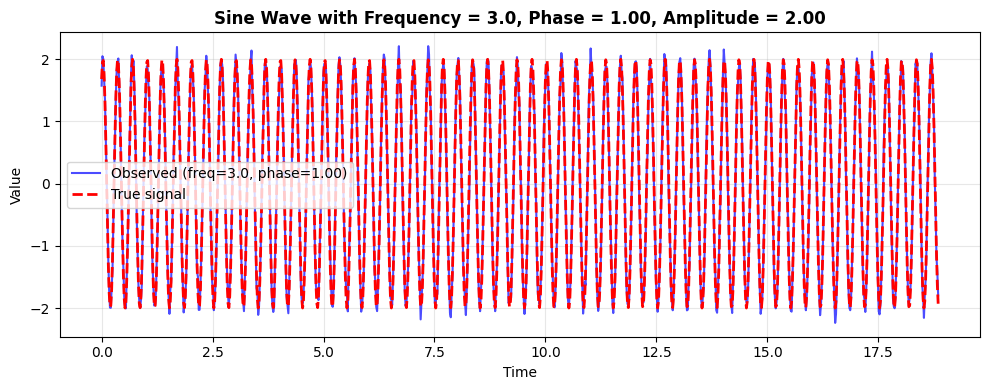

In [41]:
def simulate_sine_wave(frequency, num_points=1000, noise_std=0.1, amplitude=1.0, phase=0):
    """
    Generate a sine wave with given frequency and add noise
    
    Args:
        frequency: frequency of sine wave (parameter we want to infer)
        num_points: number of time points
        noise_std: standard deviation of Gaussian noise
        amplitude: fixed amplitude (default=1.0)
        phase: phase shift (default=0)
    
    Returns:
        observed_data: noisy sine wave observations
    """
    t = np.linspace(0, 6*pi, num_points)
    signal = amplitude * np.sin(2*pi*frequency * t + phase)
    noise = np.random.normal(0, noise_std, num_points)
    observed_data = signal + noise
    return observed_data

# Test the simulator
print("Testing simulator:")
freq_test = 3.0
phase_test = 1.0
amplitude_test = 2.0
test_data = simulate_sine_wave(freq_test, num_points=1000, noise_std=0.1, amplitude=amplitude_test, phase=phase_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
t = np.linspace(0, 6*pi, 1000)
ax.plot(t, test_data, 'b-', alpha=0.7, linewidth=1.5, label=f'Observed (freq={freq_test}, phase={phase_test:.2f})')
ax.plot(t, amplitude_test * np.sin(2*pi*freq_test * t + phase_test), 'r--', linewidth=2, label='True signal')
ax.set_title(f'Sine Wave with Frequency = {freq_test}, Phase = {phase_test:.2f}, Amplitude = {amplitude_test:.2f}', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [42]:
def generate_frequency_training_data(num_simulations=10000, freq_low=0.5, freq_high=5.0, phase_low = -3, phase_high = 3, amplitude_low = 0.5, amplitude_high = 3.0):
    
    #Generate training dataset for frequency and phase inference
    
    print(f"generating {num_simulations} samples for training")
    
    train_frequencies = []
    train_phases = []
    train_amplitudes = []
    train_data = []
    
    for i in range(num_simulations):
        # Sample frequency and phase from prior
        frequency = np.random.uniform(freq_low, freq_high)
        phase = np.random.uniform(phase_low, phase_high)
        amplitude = np.random.uniform(amplitude_low, amplitude_high)


        # Simulate observed data
        observed = simulate_sine_wave(frequency, amplitude=amplitude, phase=phase)
        
        train_frequencies.append(frequency)
        train_phases.append(phase)
        train_amplitudes.append(amplitude)
        train_data.append(observed)
        
        if (i + 1) % 2000 == 0:
            print(f"  Generated {i+1}/{num_simulations} simulations")
    
    train_frequencies = torch.FloatTensor(train_frequencies).unsqueeze(1)  # [N, 1]
    train_phases = torch.FloatTensor(train_phases).unsqueeze(1)  # [N, 1]
    train_amplitudes = torch.FloatTensor(train_amplitudes).unsqueeze(1)  # [N, 1]

    train_params = torch.cat([train_frequencies, train_phases, train_amplitudes], dim=1)  # [N, 3]
    train_data = torch.FloatTensor(np.array(train_data))  # [N, 1000]
    
    print(f"data generated")
    
    return train_params, train_data

# Generate training data
train_params, train_data = generate_frequency_training_data(num_simulations=100000)

'''
# Visualize frequency and phase distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(train_params[:, 0].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title('Training Frequency Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)

axes[1].hist(train_params[:, 1].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Training Phase Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Phase')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.3)

axes[2].hist(train_params[:, 1].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[2].set_title('Training Phase Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Phase')
axes[2].set_ylabel('Density')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''

generating 100000 samples for training
  Generated 2000/100000 simulations
  Generated 4000/100000 simulations
  Generated 6000/100000 simulations
  Generated 8000/100000 simulations
  Generated 10000/100000 simulations
  Generated 12000/100000 simulations
  Generated 14000/100000 simulations
  Generated 16000/100000 simulations
  Generated 18000/100000 simulations
  Generated 20000/100000 simulations
  Generated 22000/100000 simulations
  Generated 24000/100000 simulations
  Generated 26000/100000 simulations
  Generated 28000/100000 simulations
  Generated 30000/100000 simulations
  Generated 32000/100000 simulations
  Generated 34000/100000 simulations
  Generated 36000/100000 simulations
  Generated 38000/100000 simulations
  Generated 40000/100000 simulations
  Generated 42000/100000 simulations
  Generated 44000/100000 simulations
  Generated 46000/100000 simulations
  Generated 48000/100000 simulations
  Generated 50000/100000 simulations
  Generated 52000/100000 simulations
  G

"\n# Visualize frequency and phase distributions\nfig, axes = plt.subplots(1, 3, figsize=(12, 4))\naxes[0].hist(train_params[:, 0].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black')\naxes[0].set_title('Training Frequency Distribution', fontsize=12, fontweight='bold')\naxes[0].set_xlabel('Frequency')\naxes[0].set_ylabel('Density')\naxes[0].grid(True, alpha=0.3)\n\naxes[1].hist(train_params[:, 1].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')\naxes[1].set_title('Training Phase Distribution', fontsize=12, fontweight='bold')\naxes[1].set_xlabel('Phase')\naxes[1].set_ylabel('Density')\naxes[1].grid(True, alpha=0.3)\n\naxes[2].hist(train_params[:, 1].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')\naxes[2].set_title('Training Phase Distribution', fontsize=12, fontweight='bold')\naxes[2].set_xlabel('Phase')\naxes[2].set_ylabel('Density')\naxes[2].grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()\n"

### Create and Train Frequency Model

In [ ]:

freq_model = DINGOModel(
    data_dim=1000,
    param_dim=3,  # Now inferring frequency, phase, and amplitude
    context_dim=128,
    num_flow_layers=10,
    hidden_dim=256
)

print("model created")
print(f"  Total parameters: {sum(p.numel() for p in freq_model.parameters()):,}")

print("\nTraining")
freq_losses = train_dingo_model(
    freq_model, 
    train_params, 
    train_data, 
    num_epochs=200, 
    batch_size=256,
    lr=5e-4
)

model created
  Total parameters: 2,427,836

Training
Training DINGO-style model for 200 epochs...



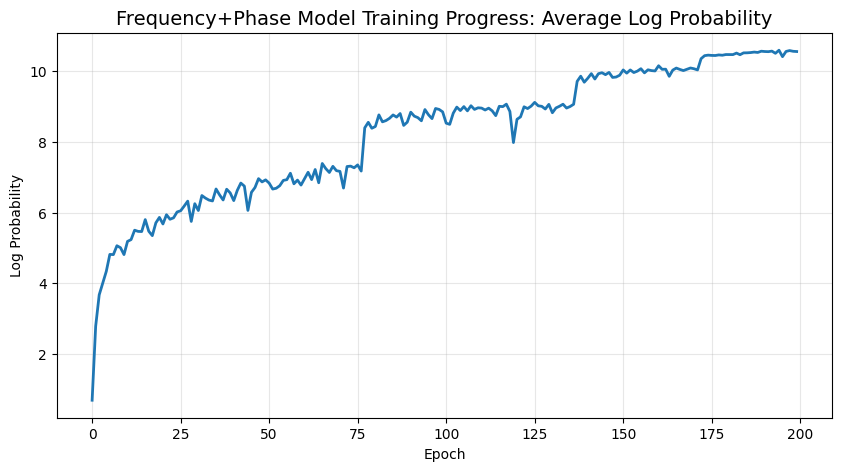

In [ ]:
#Traning Progress
plt.figure(figsize=(10, 5))
plt.plot(freq_losses, linewidth=2)
plt.title('Frequency+Phase Model Training Progress: Average Log Probability', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Log Probability')
plt.grid(True, alpha=0.3)
plt.show()

Testing frequency+phase+amplitude model on new observations:


Test 1: True Frequency = 1.0, True Phase = 0.50, True Amplitude = 1.00
  Frequency posterior: mean=0.993 ± 0.003
  Phase posterior:     mean=0.516 ± 0.027
  Amplitude posterior: mean=1.010 ± 0.009


/tmp/ipykernel_1058/1971820972.py:92: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[len(parameters) + idx2 + 1, idx].scatter(true_list[idx2], true_list[(idx2+1) % 3], color='cyan', s=200, marker='x',



Test 2: True Frequency = 2.5, True Phase = -0.30, True Amplitude = 0.80
  Frequency posterior: mean=2.498 ± 0.005
  Phase posterior:     mean=-0.235 ± 0.032
  Amplitude posterior: mean=0.809 ± 0.006

Test 3: True Frequency = 4.0, True Phase = 1.20, True Amplitude = 2.40
  Frequency posterior: mean=3.999 ± 0.005
  Phase posterior:     mean=1.219 ± 0.015
  Amplitude posterior: mean=2.399 ± 0.011


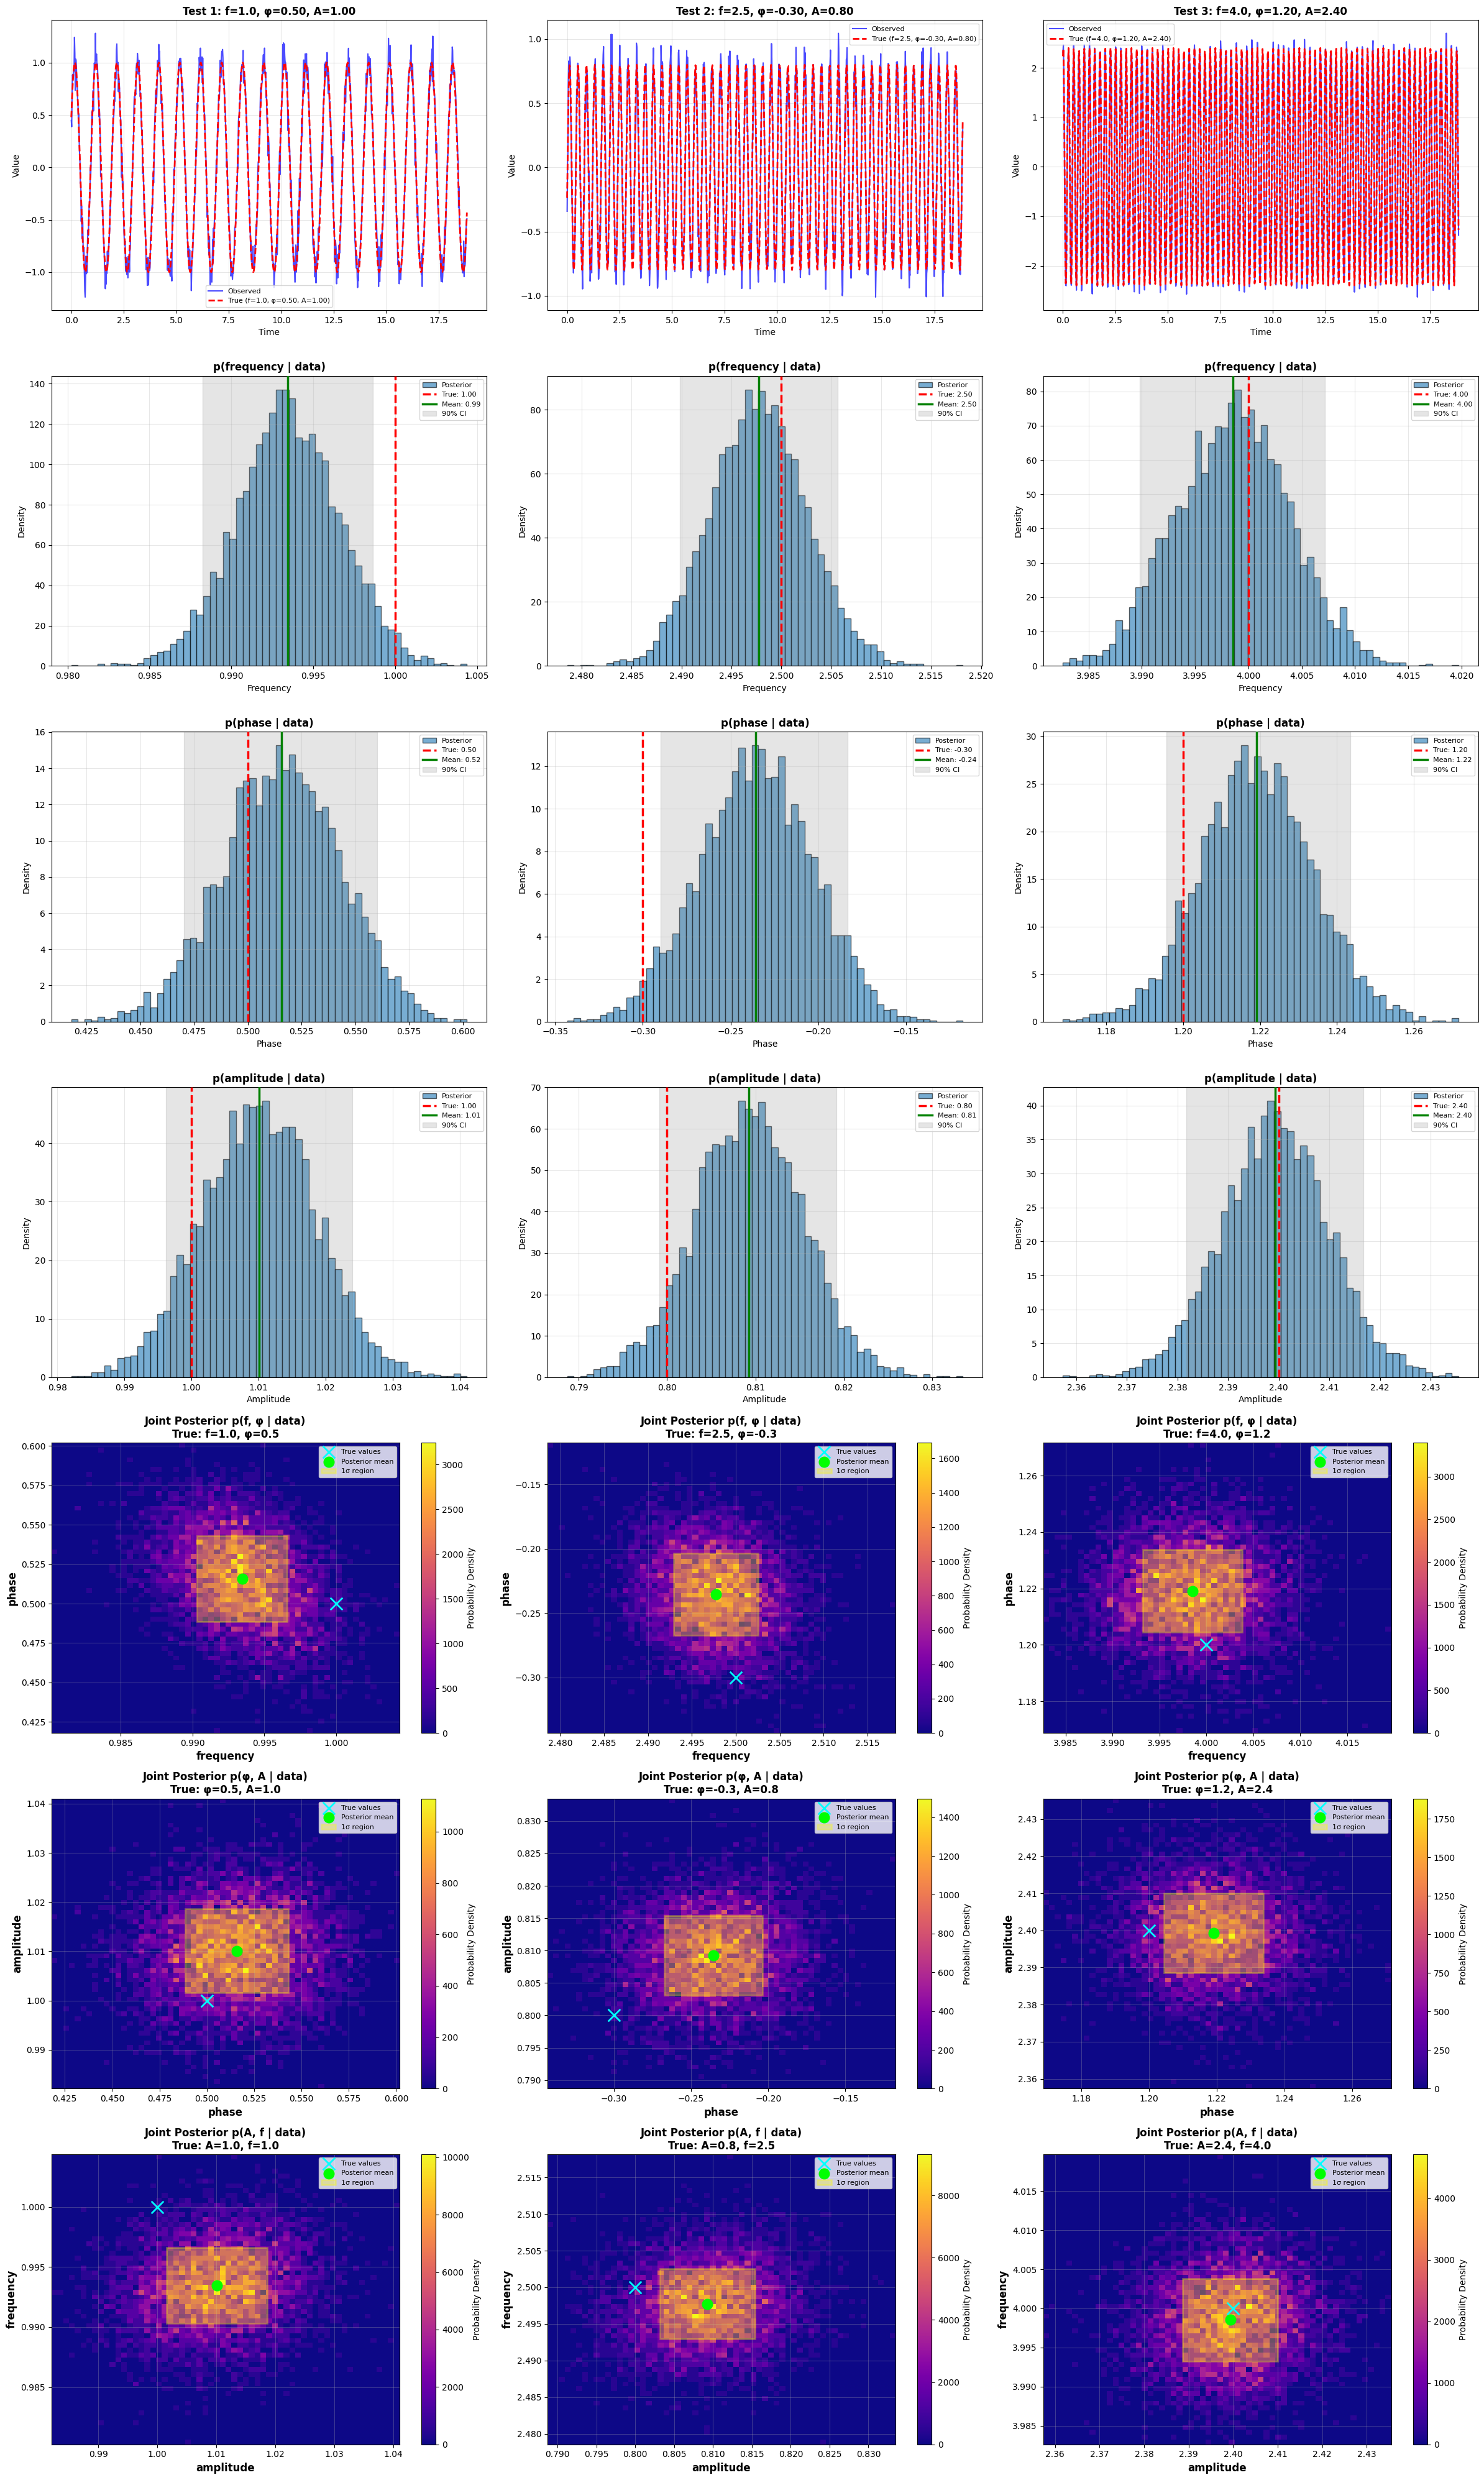

In [40]:
from matplotlib.patches import Rectangle # Rectangle where both axes' 1-sigma regions overlap

# Test on several different true frequencies, phases, and amplitudes
test_frequencies = [1.0, 2.5, 4.0]
test_phases = [0.5, -0.3, 1.2]
test_amplitudes = [1.0, 0.8, 2.4]

fig, axes = plt.subplots(7, len(test_frequencies), figsize=(8*len(test_frequencies), 40))

print("Testing frequency+phase+amplitude model on new observations:\n")

for idx, true_freq in enumerate(test_frequencies):
    true_phase = test_phases[idx]
    true_amp = test_amplitudes[idx]
    print(f"\nTest {idx+1}: True Frequency = {true_freq}, True Phase = {true_phase:.2f}, True Amplitude = {true_amp:.2f}")
    
    # Generate new observation
    observed_data = simulate_sine_wave(true_freq, phase=true_phase, amplitude=true_amp)
    
    # Infer posterior
    posterior_samples, stats = infer_with_dingo(freq_model, observed_data, num_samples=5000)
    # posterior_samples shape is [num_samples, 3] with [frequency, phase, amplitude]
    freq_samples = posterior_samples[:, 0]
    phase_samples = posterior_samples[:, 1]
    amp_samples = posterior_samples[:, 2]
    
    freq_stats = {
        'mean': np.mean(freq_samples),
        'median': np.median(freq_samples),
        'std': np.std(freq_samples),
        'q05': np.percentile(freq_samples, 5),
        'q95': np.percentile(freq_samples, 95),
    }
    
    phase_stats = {
        'mean': np.mean(phase_samples),
        'median': np.median(phase_samples),
        'std': np.std(phase_samples),
        'q05': np.percentile(phase_samples, 5),
        'q95': np.percentile(phase_samples, 95),
    }
    
    amp_stats = {
        'mean': np.mean(amp_samples),
        'median': np.median(amp_samples),
        'std': np.std(amp_samples),
        'q05': np.percentile(amp_samples, 5),
        'q95': np.percentile(amp_samples, 95),
    }
    
    parameters = ['frequency', 'phase', 'amplitude']
    ps = ['f', 'φ', 'A']
    samples_list = [freq_samples, phase_samples, amp_samples]
    stats_list = [freq_stats, phase_stats, amp_stats]
    true_list = [true_freq, true_phase, true_amp]

    print(f"  Frequency posterior: mean={freq_stats['mean']:.3f} ± {freq_stats['std']:.3f}")
    print(f"  Phase posterior:     mean={phase_stats['mean']:.3f} ± {phase_stats['std']:.3f}")
    print(f"  Amplitude posterior: mean={amp_stats['mean']:.3f} ± {amp_stats['std']:.3f}")
    
    t = np.linspace(0, 6*pi, 1000)

    # Plot observed data
    axes[0, idx].plot(t, observed_data, 'b-', alpha=0.7, linewidth=1.5, label='Observed')
    axes[0, idx].plot(t, true_amp * np.sin(2*pi*true_freq * t + true_phase), 'r--', 
                      label=f'True (f={true_freq}, φ={true_phase:.2f}, A={true_amp:.2f})', linewidth=2)
    axes[0, idx].set_title(f'Test {idx+1}: f={true_freq}, φ={true_phase:.2f}, A={true_amp:.2f}', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Time')
    axes[0, idx].set_ylabel('Value')
    axes[0, idx].legend(fontsize=8)
    axes[0, idx].grid(True, alpha=0.3)

    for idx2, _ in enumerate(parameters):
        axes[idx2 + 1, idx].hist(samples_list[idx2], bins=60, density=True, 
                      alpha=0.6, edgecolor='black', label='Posterior')
        axes[idx2 + 1, idx].axvline(true_list[idx2], color='red', linestyle='--', 
                             linewidth=2.5, label=f'True: {true_list[idx2]:.2f}', zorder=10)
        axes[idx2 + 1, idx].axvline(stats_list[idx2]['mean'], color='green', linestyle='-', 
                             linewidth=2.5, label=f"Mean: {stats_list[idx2]['mean']:.2f}", zorder=10)
        axes[idx2 + 1, idx].axvspan(stats_list[idx2]['q05'], stats_list[idx2]['q95'], alpha=0.2, color='gray', label='90% CI')
        axes[idx2 + 1, idx].set_title(f'p({parameters[idx2]} | data)', fontsize=12, fontweight='bold')
        axes[idx2 + 1, idx].set_xlabel(parameters[idx2].capitalize())
        axes[idx2 + 1, idx].set_ylabel('Density')
        axes[idx2 + 1, idx].legend(loc='upper right', fontsize=8)
        axes[idx2 + 1, idx].grid(True, alpha=0.3)


    for idx2, _ in enumerate(parameters):
        # 2D histograms for frequency vs. phase 
        h = axes[len(parameters) + idx2 + 1, idx].hist2d(samples_list[idx2], samples_list[(idx2+1) % 3], bins=60, cmap='plasma', density=True)
        plt.colorbar(h[3], ax=axes[len(parameters) + idx2 + 1, idx], label='Probability Density')
        axes[len(parameters) + idx2 + 1, idx].scatter(true_list[idx2], true_list[(idx2+1) % 3], color='cyan', s=200, marker='x',  
                            edgecolors='white', linewidth=2, label='True values', zorder=10) # Plot true values
        axes[len(parameters) + idx2 + 1, idx].scatter(stats_list[idx2]['mean'], stats_list[(idx2+1) % 3]['mean'], color='lime', s=100, marker='o', 
                            linewidth=3, label='Posterior mean', zorder=10) # Plot mean

        rect = Rectangle((stats_list[idx2]['mean'] - stats_list[idx2]['std'], stats_list[(idx2+1) % 3]['mean'] - stats_list[(idx2+1) % 3]['std']), 
                        width=2*stats_list[idx2]['std'], height=2*stats_list[(idx2+1) % 3]['std'],
                        facecolor='yellow', edgecolor='yellow', linewidth=2, 
                        alpha=0.3, label='1σ region', zorder=5)
        
        axes[len(parameters) + idx2 + 1, idx].add_patch(rect)
        axes[len(parameters) + idx2 + 1, idx].set_xlabel(parameters[idx2], fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].set_ylabel(parameters[(idx2+1) % 3], fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].set_title(f'Joint Posterior p({ps[idx2]}, {ps[(idx2+1) % 3]} | data)\nTrue: {ps[idx2]}={true_list[idx2]}, {ps[(idx2+1) % 3]}={true_list[(idx2+1) % 3]}', fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].legend(loc='upper right', fontsize=8)
        axes[len(parameters) + idx2 + 1, idx].grid(True, alpha=0.3)

    
plt.tight_layout()
plt.show()
